# Exercises - GEO4902-04 - Verification

Kjersti Stangeland, Fall 2024

# Exercise 04-01 - Analysis of point forecast

The script loads the data of two insitu wind and temperature observations and the corresponding model forecast. Note the model temperatures are in Kelvin. The data is stored as pandas dataframes, for example, for the model temperature and time: ```st1_temp.model``` , ```st1_temp.time```

1) Plot as time series the model and observation together in one plot. (for both wind and temperature)
2) Can you find out if the errors are conditional or not? Describe for all four observations/models. (You can look in the lecture slides for more details on conditional errors.)
3) Calculate the bias and root mean square error (RMSE)
4) Remove the bias and compute the RMSE again. 
5) Smooth the time series of the de-biased wind observations. e.g., with
 

```
from scipy.signal import savgol_filter

result = savgol_filter(np.array(st2_wind.model), 25, 2)

result = savgol_filter(np.array(st2_wind.model-bias2_w), 25, 1)
```

 

6) Plot the time series for observations and smoothed and de-biased models. 
7) Recalculate the RMSE values. What changed?
8) Based on this result, why can a coarser resolution model have a lower RMSE, although it is not necessarily more “accurate”? 

In [1]:
# import packages
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error # used to calculate RMSE
from scipy.signal import savgol_filter

In [2]:
# import temperature and wind data
st1_temp = pd.read_csv("https://raw.githubusercontent.com/maltemuellerm/GEO4902_exercises/master/04/data/99735temp.csv") # Edgeøya - Kapp Heuglin, Svalbard                
st2_temp = pd.read_csv("https://raw.githubusercontent.com/maltemuellerm/GEO4902_exercises/master/04/data/99754temp.csv") # Hornsund, Svalbard
st1_wind = pd.read_csv("https://raw.githubusercontent.com/maltemuellerm/GEO4902_exercises/master/04/data/99735wind.csv")                 
st2_wind = pd.read_csv("https://raw.githubusercontent.com/maltemuellerm/GEO4902_exercises/master/04/data/99754wind.csv") 

In [3]:
# set time as index 
# drop=True: Delete columns to be used as the new index.
# inplace=True: If True, modifies the DataFrame in place (do not create a new object).
st1_temp.set_index('time', drop=True, inplace=True)
st1_wind.set_index('time', drop=True, inplace=True)
st2_temp.set_index('time', drop=True, inplace=True)
st2_wind.set_index('time', drop=True, inplace=True)

In [4]:
# Convert index to datetime format
st1_wind.index = pd.to_datetime(st1_wind.index)
st1_temp.index = pd.to_datetime(st1_temp.index)

st2_wind.index = pd.to_datetime(st2_wind.index)
st2_temp.index = pd.to_datetime(st2_temp.index)

In [5]:
# Converting model data to Celcius
st1_temp['model'] = st1_temp['model'] - 273.15
st2_temp['model'] = st2_temp['model'] - 273.15

### 1) Plot model and observation as time series (wind and temperature)

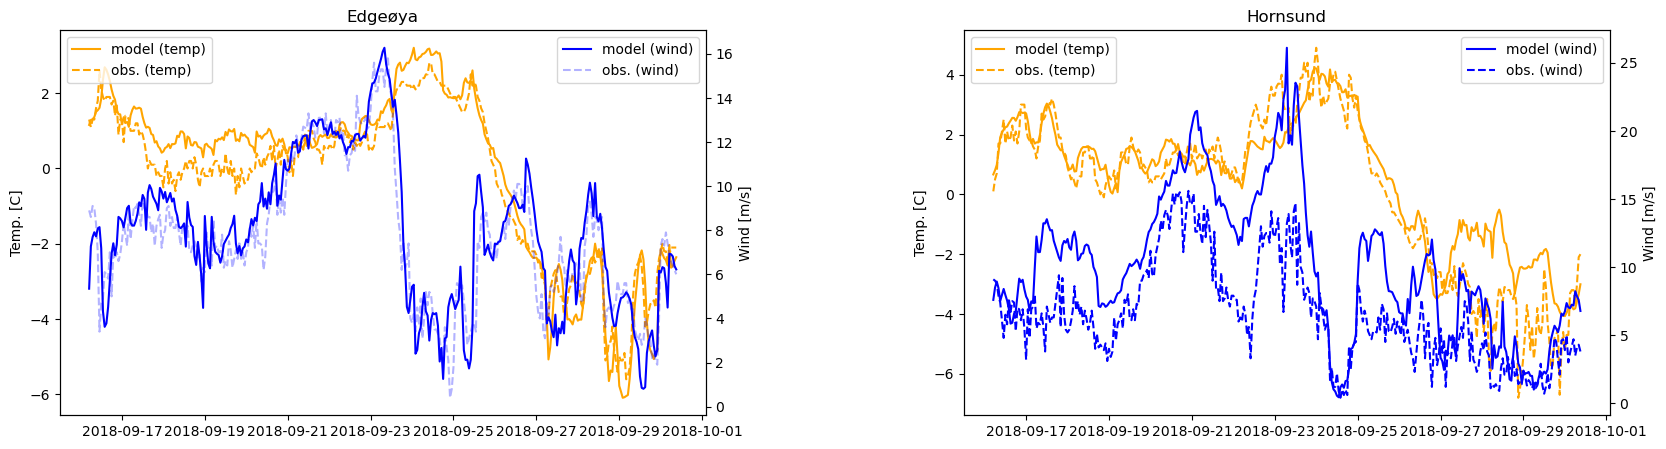

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

# Temperature plot, Edgeøya
ax[0].plot(st1_temp.model, color= 'orange', linestyle='-', label='model (temp)')
ax[0].plot(st1_temp.obs, color= 'orange', linestyle='--', label='obs. (temp)')

# Wind plot, Edgeøya
ax0_wind = ax[0].twinx()
ax0_wind.plot(st1_wind.model, color= 'blue', linestyle='-', label='model (wind)')
ax0_wind.plot(st1_wind.obs, color= 'blue', linestyle='--', alpha=0.3, label='obs. (wind)')

ax[0].set_ylabel('Temp. [C]')
ax0_wind.set_ylabel('Wind [m/s]')
ax[0].set_title('Edgeøya')
ax[0].legend(loc='upper left')
ax0_wind.legend(loc='upper right')


# Temperature plot, Hornsund
ax[1].plot(st2_temp.model, color= 'orange', linestyle='-', label='model (temp)')
ax[1].plot(st2_temp.obs, color= 'orange', linestyle='--', label='obs. (temp)')

# Wind plot, Hornsund
ax1_wind = ax[1].twinx()
ax1_wind.plot(st2_wind.model, color= 'blue', linestyle='-', label='model (wind)')
ax1_wind.plot(st2_wind.obs, color= 'blue', linestyle='--', label='obs. (wind)')

ax[1].set_ylabel('Temp. [C]')
ax1_wind.set_ylabel('Wind [m/s]')
ax[1].set_title('Hornsund')
ax[1].legend(loc='upper left')
ax1_wind.legend(loc='upper right')


### 2) Can you find out if the errors are conditional or not? Describe for all four observations/models.

__Edgeøya:__

- Overall, the model and observations for both temperature and wind coincide pretty well. At the beginning of the timeseries, the model forecasted higher temperatures than what was observed. At the same time, the model also overestimated the winds. 

__Hornsund:__
- The wind forecast is clearly overshooting the observed winds, whereas the modelled temperauture coincides more with the observed values. Here, there is even one point where the modelled wind is larger than the observed, and at the same moment in time, the modelled temperatures were lower than the observed. 

I do not see a clear pattern and whether or not the errors are conditional just by looking at the plots. So I will try to plot the error as obs. - model. 

In [7]:
error_temp_e = st1_temp.obs - st1_temp.model
error_wind_e = st1_wind.obs - st1_wind.model

error_temp_h = st2_temp.obs - st2_temp.model
error_wind_h = st2_wind.obs - st2_wind.model

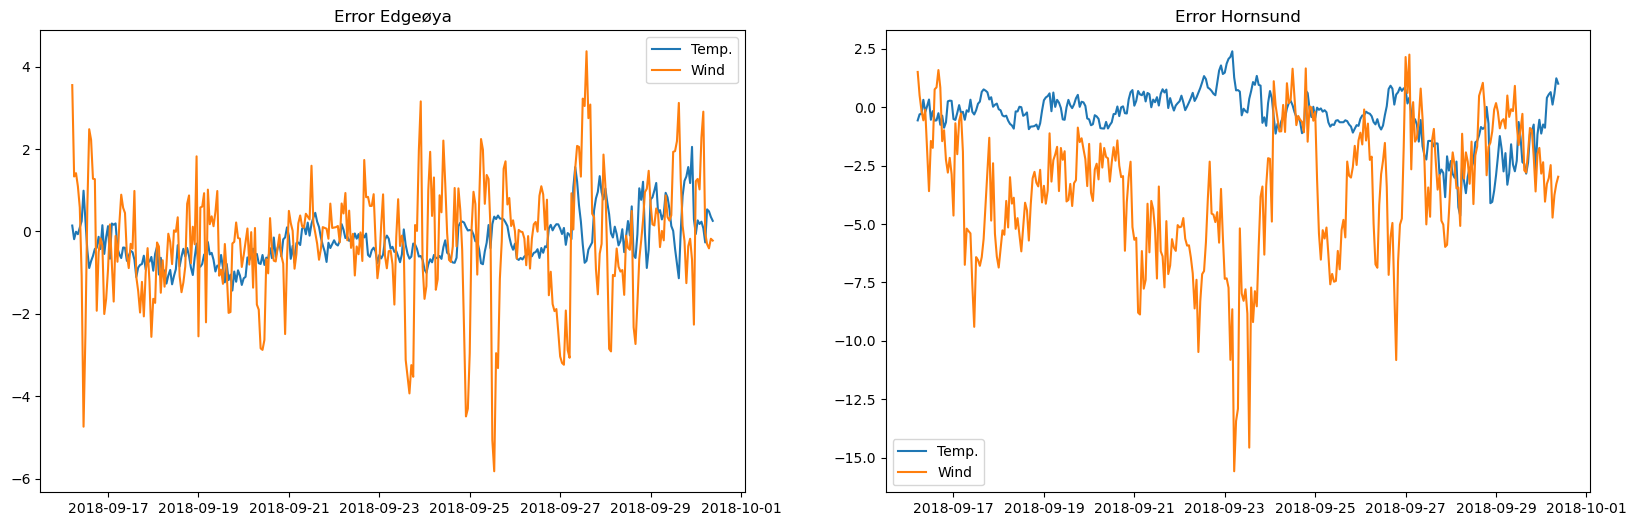

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(error_temp_e, label = 'Temp.')
ax[0].plot(error_wind_e, label = 'Wind')
ax[0].set_title('Error Edgeøya')
ax[0].legend()

ax[1].plot(error_temp_h, label = 'Temp.')
ax[1].plot(error_wind_h, label = 'Wind')
ax[1].set_title('Error Hornsund')
ax[1].legend()

- The wind has a large and fluctuating error in both locations, whereas the temperature has a lower overall error and lower fluctuations. Hornsund sticks out as the wind has large negative errors, meaning that the model forecasted alot more wind than what was observed.

### 3) Calculate the bias and root mean square error (RMSE)

Assuming:
- bias and RMSE (wind) for both locations
- bias and RMSE (temp) for both locations

In [9]:
# Edgeøya, temp

N = len(st1_temp.index)

# Using eq. 8.2 in the compendium for the bias
bias_temp_e = np.sum(st1_temp.model - st1_temp.obs)/N

# Using sklearn metrics for RMSE
rmse_temp_e = root_mean_squared_error(st1_temp.obs, st1_temp.model)

In [10]:
# Edgeøya, wind

N = len(st1_wind.index)

# Using eq. 8.2 in the compendium for the bias
bias_wind_e = np.sum(st1_wind.model - st1_wind.obs)/N

# Using sklearn metrics for RMSE
rmse_wind_e = root_mean_squared_error(st1_wind.obs, st1_wind.model)

In [11]:
# Hornsund, temp

N = len(st2_temp.index)

# Using eq. 8.2 in the compendium for the bias
bias_temp_h = np.sum(st2_temp.model - st2_temp.obs)/N

# Using sklearn metrics for RMSE
rmse_temp_h = root_mean_squared_error(st2_temp.obs, st2_temp.model)

In [12]:
# Hornsund, wind

N = len(st2_wind.index)

# Using eq. 8.2 in the compendium for the bias
bias_wind_h = np.sum(st2_wind.model - st2_wind.obs)/N

# Using sklearn metrics for RMSE
rmse_wind_h = root_mean_squared_error(st2_wind.obs, st2_wind.model)

In [13]:
print('Bias and RMSE')
print(f'Temperature Edgeøya: {bias_temp_e}, {rmse_temp_e}')
print(f'Wind Edgeøya: {bias_wind_e}, {rmse_wind_e}')
print(f'Temperature Hornsund: {bias_temp_h}, {rmse_temp_h}')
print(f'Wind Hornsund: {bias_wind_h}, {rmse_wind_h}')

Bias and RMSE
Temperature Edgeøya: 0.2538730833887232, 0.6173991573226766
Wind Edgeøya: 0.26423877908625526, 1.4738936339513473
Temperature Hornsund: 0.4029635342684885, 1.1904901680148419
Wind Hornsund: 3.587759688024745, 4.583219928939332


- __Bias__: A measure to see if the model consistently over- or underpredcits. 
- We see a very large bias for the wind in Hornsund

- __RMSE__: Average magnitude of error for model vs observations('truth'). 
- Again, wind in Hornsund has the largest value, and can be said to be the least 'accurate'. 

### 4) Remove the bias and compute the RMSE again. 

In [14]:
unbiased_temp_e = st1_temp.model - bias_temp_e
unbiased_wind_e = st1_wind.model - bias_wind_e

unbiased_temp_h = st2_temp.model - bias_temp_h
unbiased_wind_h = st2_wind.model - bias_wind_h

In [15]:
unbiased_rmse_temp_e = root_mean_squared_error(st1_temp.obs, unbiased_temp_e)
unbiased_rmse_wind_e = root_mean_squared_error(st1_wind.obs, unbiased_wind_e)

unbiased_rmse_temp_h = root_mean_squared_error(st2_temp.obs, unbiased_temp_h)
unbiased_rmse_wind_h = root_mean_squared_error(st2_wind.obs, unbiased_wind_h)

In [16]:
print('Bias removed, unbiased RMSE:')
print(f'Temperature, Edgeøya: {unbiased_rmse_temp_e}')
print(f'Temperature, Hornsund: {unbiased_rmse_temp_h}')
print(f'Wind, Edgeøya: {unbiased_rmse_wind_e}')
print(f'Wind, Hornsund: {unbiased_rmse_wind_h}')

Bias removed, unbiased RMSE:
Temperature, Edgeøya: 0.5627878614482135
Temperature, Hornsund: 1.120217492360236
Wind, Edgeøya: 1.450013900564168
Wind, Hornsund: 2.8519967282609646


### 5) Smooth the time series of the de-biased wind observations.

In [17]:
smooth_wind_e = savgol_filter(st1_wind.model - bias_wind_e, 25, 1)
smooth_wind_h = savgol_filter(st2_wind.model - bias_wind_h, 25, 1)

### 6) Plot the time series for observations and smoothed and de-biased models. 

Text(0.5, 1.0, 'Hornsund')

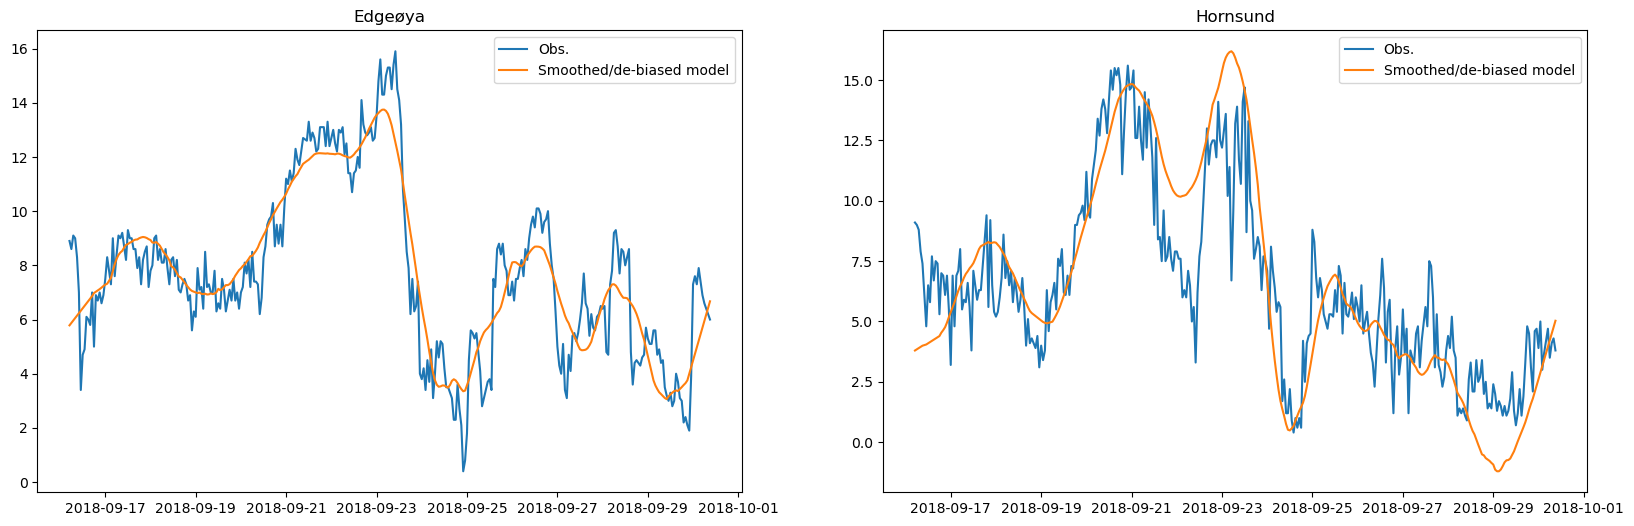

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].plot(st1_wind.index, st1_wind.obs, label ='Obs.')
ax[0].plot(st1_wind.index, smooth_wind_e, label='Smoothed/de-biased model')
ax[0].legend()
ax[0].set_title('Edgeøya')

ax[1].plot(st2_wind.index, st2_wind.obs, label ='Obs.')
ax[1].plot(st2_wind.index, smooth_wind_h, label='Smoothed/de-biased model')
ax[1].legend()
ax[1].set_title('Hornsund')

### 7) Recalculate the RMSE values. What changed?

In [19]:
new_rmse_wind_e = root_mean_squared_error(st1_wind.obs, smooth_wind_e)
new_rmse_wind_h = root_mean_squared_error(st2_wind.obs, smooth_wind_h)

print('New RMSE (unbiased, smooth)')
print(f'Wind Edgeøya: {new_rmse_wind_e}')
print(f'Wind Hornsund: {new_rmse_wind_h}')
print()
print('RMSE (unbiased, un-smooth)')
print(f'Wind Edgeøya: {unbiased_rmse_wind_e}')
print(f'Wind Hornsund: {unbiased_rmse_wind_h}')
print()
print('RMSE (biased, un-smooth)')
print(f'Wind Edgeøya: {rmse_wind_e}')
print(f'Wind Hornsund: {rmse_wind_h}')

New RMSE (unbiased, smooth)
Wind Edgeøya: 1.266700415012304
Wind Hornsund: 2.236045053059299

RMSE (unbiased, un-smooth)
Wind Edgeøya: 1.450013900564168
Wind Hornsund: 2.8519967282609646

RMSE (biased, un-smooth)
Wind Edgeøya: 1.4738936339513473
Wind Hornsund: 4.583219928939332


The bias is a measure of how much the model continously overprecits or underpredicts with respect to the observations. Removing the bias, yields a lower RMSE. Unbiased models mean that there is not a systematic error, but that the inaccuracies are more random. 

Smoothing reduces the high frequency variability, and hence lowers the RMSE. The modelled values get less extreme values.

### 8) Based on this result, why can a coarser resolution model have a lower RMSE, although it is not necessarily more “accurate”? 

Coarser models often provides a lower RMSE because the lower resolution does not have high frequency variability. The resolution itself makes the data smoother both in the spatial and temporal scales. Hence, the model may look more accurate from the RMSE but is in fact not more accurate.

# Exercise 04-02 - Categorical verification

1) Compute the fraction correct, frequency bias, probability of detection, threat score, and equitable threat score. For each score, write a sentence or two how this value can be interpreted.

<table>
  <tr>
    <td>
      <img src="/Users/kjesta/GEO4902/Exercise 4/image-5.png" alt="Alternative text" width="300" />
    </td>
    <td>
      <img src="/Users/kjesta/GEO4902/Exercise 4/contingency.png" alt="Alternative text" width="300" />
    </td>
  </tr>
</table>



Fraction correct (eq. 8.12):

$
FC = \frac{hits + correct negatives}{total}
$

Frequency bias (eq. 8.13):

$
FB = \frac{hits + false alarms}{hits + misses}
$

Probability of detection (I think this is eq. 8.14):

$
HR = \frac{hits}{hits + misses}
$

Threat score (eq. 8.16):

$
TS = \frac{hits}{hits + misses + false alarms}
$

Equitable threat score (eq. 8.17, 8.18):

$
ETS = \frac{hits - hits_{random}}{hits + misses + false alarms - hits_{random}}
$


$
hits_{random} = \frac{(hits + misses)(hits + false alarms)}{total}
$

In [20]:
def scores(a, b, c, d, x):
    random = ((a+c)*(a+b))/x
    FC = (a+d)/x
    FB = (a+b)/(a+c)
    HR = a/(a+c)
    TS = a/(a+b+c)
    ETS = (a-random)/(a+c+b-random)
    
    return FC, FB, HR, TS, ETS

In [21]:
hits = 28
false_alarms = 72
misses = 23
correct_negatives = 2680
total = 2803

FC, FB, HR, TS, ETS = scores(hits, false_alarms, misses, correct_negatives, total)

In [22]:
print(f'Fraction score: {FC}')
print(f'Frequency bias: {FB}')
print(f'Hit rate: {HR}')
print(f'Threat score: {TS}')
print(f'Equitable threat score: {ETS}')

Fraction score: 0.9661077417053158
Frequency bias: 1.9607843137254901
Hit rate: 0.5490196078431373
Threat score: 0.22764227642276422
Equitable threat score: 0.21604562088386045


- Fraction score: The fraction of forecastes which were correctd, either by a hit or a correct miss. Which here is at 96%.
- Frequency bias: How often the event is forecasted, either as a correct hit or a false positive. Occurence rate of an event in the forecast vs how often it actually occurs. 
- Hit rate/probability of detection: How many correct events were forecasted vs how many actually happened. 
- Threat score: "performance measure of rare events". Correct negatives may dominate the table for very rare events, here: 95% fraction score seems very good, but its is due to the correct negatives being "easy points" for the forecast. "The threat score can be interpreted as the percentage of correctly forecasted events from the ones which were either forecasted or observed. A perfect fore- cast yields the score 1."
- Equitable threat score: "In order to allow for the number of hits that would have occurred just by chance, is the equitable threat score." ... "and can be interpreted as the number of random hits expected by forecasts independent of observations. As an example, it is easier to correctly forecast rain occurrence in a wet climate rather than in a dry one, which needs to be accounted for in the skill assessment."

2) It was pointed out by Gilbert (1884) that the fraction correct score can be manipulated if just “no tornado” is forecasted. Provide the contingency table for this situation and calculate the fraction correct score to verify Gilberts’s critique. 

In [23]:
hits = 0
false_alarms = 0
misses = 23 + 28
correct_negatives = 2680 + 72
total = 2803

FC, FB, HR, TS, ETS = scores(hits, false_alarms, misses, correct_negatives, total)

In [24]:
print('Only no-tornado forecasted, Gilberts manipulation:')
print(f'Fraction score: {FC}')
print(f'Frequency bias: {FB}')
print(f'Hit rate: {HR}')
print(f'Threat score: {TS}')
print(f'Equitable threat score: {ETS}')

Only no-tornado forecasted, Gilberts manipulation:
Fraction score: 0.981805208704959
Frequency bias: 0.0
Hit rate: 0.0
Threat score: 0.0
Equitable threat score: 0.0


Gilberts point was that the fraction score of a forecast who never forecasts the extremes, which here is a tornado, will give a false impression of being trustworthy. 

3) The results of Gilbert led to the development of more meaningful verification scores. And the Equitable threat score is also called the Gilbert skill score. What is the ETS in case of the manipulated contingency table?

...zero? Meaning no skill in predicting a tornado?